In [ ]:
# cifar-10-python.tar.gz extraction code
import os
import tarfile
from pathlib import Path

# Define the filename
cifar_file = "cifar-10-python.tar.gz"

# Get the current working directory
current_dir = Path.cwd()
file_path = current_dir / cifar_file

# Check if file exists
if file_path.exists():
    print(f"Found {cifar_file} at: {file_path}")
else:
    print(f"Error: {cifar_file} not found in {current_dir}")
    
# Create extraction directory
extract_dir = current_dir / "cifar-10-batches"
extract_dir.mkdir(exist_ok=True)

# Extract the archive
try:
    with tarfile.open(file_path, "r:gz") as tar:
        # Check for any harmful files
        for member in tar.getmembers():
            if ".." in member.name or member.name.startswith("/"):
                raise Exception("Potentially harmful file detected in archive")
        
        # Extract all files
        tar.extractall(path=extract_dir)
        print(f"Successfully extracted to: {extract_dir}")
except Exception as e:
    print(f"Error during extraction: {str(e)}")
    

# Image Classification using Deep Learning

This notebook implements a complete image classification pipeline using the CIFAR-10 dataset and deep learning techniques.

## Import Required Libraries

Let's import all the necessary libraries for our image classification project:

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from pathlib import Path

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Utilities for evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check if GPU is available
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available:  []


## Load and Prepare the Dataset

Now we'll load the CIFAR-10 dataset that we've already extracted and prepare it for training.

Training data shape: (10000, 32, 32, 3)
Training labels shape: (10000,)
Test data shape: (2000, 32, 32, 3)
Selected classes: ['cat', 'dog']


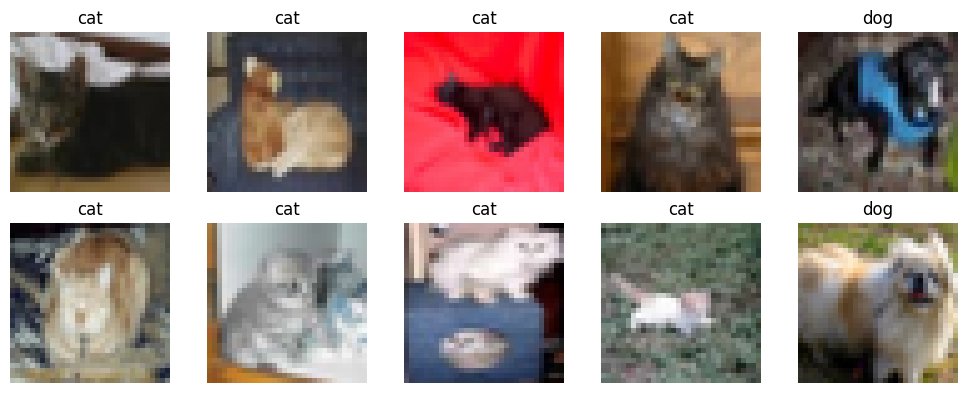

In [5]:
# Data Loading and Preprocessing

def load_cifar10_batch(file):
    """Load a batch of the CIFAR-10 dataset"""
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch[b'data'], batch[b'labels']

def load_cifar10_data(classes_to_use=[3, 5]):  # 3=cat, 5=dog
    """Load CIFAR-10 data and filter for specific classes"""
    cifar_dir = Path("cifar-10-batches") / "cifar-10-batches-py"
    
    # Load training batches
    x_train = []
    y_train = []
    
    for i in range(1, 6):
        data, labels = load_cifar10_batch(cifar_dir / f"data_batch_{i}")
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # reshape inline
        
        # Filter for selected classes
        mask = np.isin(labels, classes_to_use)
        x_train.append(data[mask])
        y_train.extend(np.array(labels)[mask])
    
    x_train = np.concatenate(x_train)
    y_train = np.array(y_train)
    
    # Load test batch
    x_test, y_test = load_cifar10_batch(cifar_dir / "test_batch")
    x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    # Filter test data
    test_mask = np.isin(y_test, classes_to_use)
    x_test = x_test[test_mask]
    y_test = np.array(y_test)[test_mask]
    
    # Get class names
    with open(cifar_dir / "batches.meta", 'rb') as f:
        meta = pickle.load(f, encoding='bytes')
    class_names = [label.decode('utf-8') for label in meta[b'label_names']]
    
    # Remap class indices to [0, num_classes-1]
    class_map = {c: i for i, c in enumerate(classes_to_use)}
    y_train = np.array([class_map[y] for y in y_train])
    y_test = np.array([class_map[y] for y in y_test])
    
    selected_classes = [class_names[i] for i in classes_to_use]
    
    return (x_train, y_train), (x_test, y_test), selected_classes

# Load only cat (3) and dog (5) classes
(x_train, y_train), (x_test, y_test), class_names = load_cifar10_data(classes_to_use=[3, 5])

# Normalize pixel values to be between -1 and 1 (common for GANs)
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

# Print dataset info
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Selected classes: {class_names}")

# Visualize some examples
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((x_train[i] * 127.5 + 127.5).astype(np.uint8))
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

## VAE

In [ ]:
# VAE Implementation
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(latent_dim=128):
    encoder_inputs = keras.Input(shape=(32, 32, 3))
    
    # More filters and layers
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    
    # Distribution parameters
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

def build_decoder(latent_dim=128):
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    # Larger initial representation
    x = layers.Dense(4 * 4 * 512, activation="relu")(latent_inputs)
    x = layers.Reshape((4, 4, 512))(x)
    
    # More complex upsampling path
    x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    
    # Additional convolutions at each resolution
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    
    # Output layer
    decoder_outputs = layers.Conv2D(3, 3, activation="tanh", padding="same")(x)
    
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

# Build VAE model
latent_dim = 128
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

# Define VAE as a Model with custom train_step and call method
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
        
    def call(self, inputs, training=None):
        """Process the input through encoder and decoder"""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed
        
    # Modify the train_step method in your VAE class
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3))
            )
            
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            
            # Add weight to reconstruction loss (beta < 1 emphasizes reconstruction quality)
            beta = 0.1  # Try values between 0.01 and 0.5
            total_loss = reconstruction_loss + beta * kl_loss
        
        # Rest of the method remains the same
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    # Fix for the VAE generate method
    def generate(self, n_samples):
        """Generate new images from random latent vectors"""
        # Explicitly use latent_dim=128 (the dimension defined when building the decoder)
        z = tf.random.normal(shape=(n_samples, 128))  # Hardcode the correct latent dimension
        return self.decoder(z)
    
# Create and compile VAE model
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # Add a dummy loss that won't be used (since we override train_step)
    loss=tf.keras.losses.MeanSquaredError()
)

# Print model summaries
encoder.summary()
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │      1,792 │ input_layer_16[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ conv2d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 4, 4, 512) │  1,180,160 │ conv2d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 8192)      │          0 │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 512)       │  4,194,816 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     65,664 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     65,664 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_4          │ (None, 128)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,877,120 (22.42 MB)

 Trainable params: 5,877,120 (22.42 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,644,163 (10.09 MB)

 Trainable params: 2,644,163 (10.09 MB)

 Non-trainable params: 0 (0.00 B)

## GAN

In [25]:
# GAN Implementation with similarity-based discriminator
# Add this function to improve training stability
def gradient_penalty(discriminator, real_samples, fake_samples):
    """Implements gradient penalty for WGAN-GP"""
    batch_size = tf.shape(real_samples)[0]
    
    # Generate random interpolation points between real and fake
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated = real_samples + alpha * (fake_samples - real_samples)
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        # Get discriminator output for interpolated images
        pred = discriminator([real_samples, interpolated], training=True)
    
    # Calculate gradients w.r.t. interpolated images
    gradients = tape.gradient(pred, interpolated)
    # Compute L2 norm of gradients
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    # Calculate gradient penalty
    gradient_penalty = tf.reduce_mean((gradients_norm - 1.0) ** 2)
    
    return gradient_penalty

def build_generator(latent_dim=100):
    model = keras.Sequential([
        # Foundation for 4x4 image
        layers.Dense(4 * 4 * 256, input_dim=latent_dim),
        layers.Reshape((4, 4, 256)),
        
        # Upsampling to 8x8
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        
        # Upsampling to 16x16
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        
        # Upsampling to 32x32
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        
        # Output layer with tanh activation
        layers.Conv2D(3, kernel_size=3, padding="same", activation="tanh")
    ], name="generator")
    
    return model

def build_similarity_discriminator():
    """Builds a siamese-like network that evaluates similarity between images"""
    # Input layers for real and generated images
    input_real = layers.Input(shape=(32, 32, 3))
    input_generated = layers.Input(shape=(32, 32, 3))
    
    # Shared feature extraction network
    feature_extractor = keras.Sequential([
        layers.Conv2D(32, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Conv2D(256, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(512)
    ])
    
    # Extract features from both inputs
    features_real = feature_extractor(input_real)
    features_generated = feature_extractor(input_generated)
    
    # Implement mini-batch discrimination as a custom layer
    class MiniBatchDiscrimination(layers.Layer):
        def __init__(self, num_kernels=32, kernel_dim=16, **kwargs):
            super(MiniBatchDiscrimination, self).__init__(**kwargs)
            self.num_kernels = num_kernels
            self.kernel_dim = kernel_dim
            
        def build(self, input_shape):
            self.kernel = self.add_weight(
                name='kernel',
                shape=(input_shape[-1], self.num_kernels * self.kernel_dim),
                initializer='glorot_uniform',
                trainable=True
            )
            super(MiniBatchDiscrimination, self).build(input_shape)
            
        def call(self, inputs):
            # Transform inputs into kernel space
            x = keras.backend.dot(inputs, self.kernel)
            x = keras.backend.reshape(x, (-1, self.num_kernels, self.kernel_dim))
            
            # Calculate L1 distance between samples
            diffs = keras.backend.expand_dims(x, axis=3) - keras.backend.expand_dims(
                keras.backend.permute_dimensions(x, (1, 2, 0)), axis=0)
            abs_diffs = keras.backend.sum(keras.backend.abs(diffs), axis=2)
            
            # Apply negative exponential to get similarity
            exp_diffs = keras.backend.exp(-abs_diffs)
            
            # Sum over all samples in batch
            sum_over_batch = keras.backend.sum(exp_diffs, axis=2)
            
            # Concatenate with original input
            return keras.backend.concatenate([inputs, sum_over_batch], axis=1)
    
    # Apply mini-batch discrimination
    enhanced_features_real = MiniBatchDiscrimination(32, 16)(features_real)
    enhanced_features_generated = MiniBatchDiscrimination(32, 16)(features_generated)
    
    # Concatenate feature vectors
    concatenated = layers.Concatenate()([enhanced_features_real, enhanced_features_generated])
    
    # Similarity scoring network
    x = layers.Dense(256, activation="relu")(concatenated)
    x = layers.Dropout(0.3)(x)
    similarity_score = layers.Dense(1, activation="sigmoid")(x)
    
    # Create model
    similarity_discriminator = keras.Model(
        inputs=[input_real, input_generated], 
        outputs=similarity_score, 
        name="similarity_discriminator"
    )
    
    return similarity_discriminator

# Build GAN components
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_similarity_discriminator()

# Compile the discriminator
discriminator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy"
)

# Create GAN model
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.d_step_counter = 0
        
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
        # Metrics
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        
        # Train discriminator with gradient penalty
        with tf.GradientTape() as d_tape:
            # Generate images
            generated_images = self.generator(random_latent_vectors, training=True)
            
            # Get discriminator predictions
            real_pred = self.discriminator([real_images, real_images], training=True)
            fake_pred = self.discriminator([real_images, generated_images], training=True)
            
            # Discriminator loss: real images should be similar (0), generated should be different (1)
            d_loss_real = self.loss_fn(tf.zeros_like(real_pred), real_pred)
            d_loss_fake = self.loss_fn(tf.ones_like(fake_pred), fake_pred)
            
            # Add gradient penalty
            gp = gradient_penalty(self.discriminator, real_images, generated_images)
            
            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake + 10.0 * gp
        
        # Get discriminator gradients
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        
        # Update discriminator (don't update too often)
        if self.d_step_counter % 5 == 0:
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_weights))
        self.d_step_counter += 1
        
        # Train generator
        with tf.GradientTape() as g_tape:
            # Generate images
            generated_images = self.generator(random_latent_vectors, training=True)
            
            # Get discriminator predictions on generated images
            fake_pred = self.discriminator([real_images, generated_images], training=False)
            
            # Generator loss: generated should appear similar to real (0)
            g_loss = self.loss_fn(tf.zeros_like(fake_pred), fake_pred)
        
        # Get generator gradients
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_weights)
        
        # Update generator
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_weights))
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    
    def generate(self, n_samples):
        """Generate new images"""
        random_latent_vectors = tf.random.normal(shape=(n_samples, latent_dim))
        return self.generator(random_latent_vectors)

# Create and compile GAN model with lower learning rates
gan = GAN(generator, discriminator)
gan.compile(
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),  # Lower learning rate
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),  # Lower learning rate 
    loss_fn=keras.losses.BinaryCrossentropy()
)

# Display model summaries
generator.summary()
discriminator.summary()

d:\FAST\Semester 8\GenAI\Assignments\Assignment-2\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\FAST\Semester 8\GenAI\Assignments\Assignment-2\venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103,811 (4.21 MB)

 Trainable params: 1,103,363 (4.21 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "similarity_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 512)       │    913,216 │ input_layer_19[0… │
│ (Sequential)        │                   │            │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mini_batch_discrim… │ (None, 544)       │    262,144 │ sequential_2[0][… │
│ (MiniBatchDiscrimi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mini_batch_discrim… │ (None, 544)       │    262,144 │ sequential_2[1][… │
│ (MiniBatchDiscrimi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1088)      │          0 │ mini_batch_discr… │
│ (Concatenate)       │                   │            │ mini_batch_discr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │    278,784 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │        257 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,716,545 (6.55 MB)

 Trainable params: 1,716,545 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

## Train and Evaluation

In [32]:
# Training and Evaluation

# Create image grid visualization function
# Make sure latent dimensions are consistent for both models
latent_dim_vae = 128  # Already defined in your VAE code
latent_dim_gan = 100  # Already defined in your GAN code

# Fix the plot_generated_images function to respect each model's latent dimension
# Fixed plot_generated_images function without changing models
def plot_generated_images(model, n_rows=4, n_cols=4, is_vae=False):
    n_samples = n_rows * n_cols
    
    # Generate images with explicit latent dimensions
    if is_vae:
        # For VAE, explicitly use latent_dim=128
        z = tf.random.normal(shape=(n_samples, 128))  # Hardcode VAE's latent_dim
        generated_images = model.decoder(z)
    else:
        # For GAN, explicitly use latent_dim=100
        z = tf.random.normal(shape=(n_samples, 100))  # Hardcode GAN's latent_dim
        generated_images = model.generator(z)
    
    # Scale back to [0, 255] for display
    generated_images = (generated_images * 127.5 + 127.5).numpy().astype(np.uint8)
    
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_samples):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    
    return generated_images

# Create callback for saving generator and visualizing progress
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=16, latent_dim=100, frequency=5):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.frequency = frequency
        self.random_vectors = tf.random.normal([num_img, latent_dim])
        self.progress_images = []
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            generated_images = self.model.generator(self.random_vectors, training=False)
            generated_images = (generated_images * 127.5 + 127.5).numpy().astype(np.uint8)
            
            plt.figure(figsize=(8, 8))
            for i in range(self.num_img):
                plt.subplot(4, 4, i+1)
                plt.imshow(generated_images[i])
                plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'gan_progress_epoch_{epoch+1}.png')
            plt.close()
            
            # Save generator at checkpoints
            self.model.generator.save(f'generator_epoch_{epoch+1}.h5')
            
            # Store progress images
            self.progress_images.append((epoch+1, generated_images))

class VAEMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=16, latent_dim=128, frequency=5):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.frequency = frequency
        self.progress_images = []
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0:
            # Generate random samples
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generated_images = self.model.decoder(random_latent_vectors)
            generated_images = (generated_images * 127.5 + 127.5).numpy().astype(np.uint8)
            
            plt.figure(figsize=(8, 8))
            for i in range(self.num_img):
                plt.subplot(4, 4, i+1)
                plt.imshow(generated_images[i])
                plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'vae_progress_epoch_{epoch+1}.png')
            plt.close()
            
            # Save decoder at checkpoints
            self.model.decoder.save(f'vae_decoder_epoch_{epoch+1}.h5')
            
            # Store progress images
            self.progress_images.append((epoch+1, generated_images))


## Train VAE

In [24]:

# Train the VAE - fixed validation data format
print("\nTraining VAE...")
vae_history = vae.fit(
    x_train,  # Input data
    epochs=50,
    batch_size=128,
    # validation_data=x_test,  # Just pass x_test without parentheses
    callbacks=[VAEMonitor(frequency=5)]
)



Training VAE...
Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 313ms/step - kl_loss: 44.1226 - loss: 705.6907 - reconstruction_loss: 701.2784
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - kl_loss: 111.0051 - loss: 347.4097 - reconstruction_loss: 336.3092
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 340ms/step - kl_loss: 139.7255 - loss: 283.4924 - reconstruction_loss: 269.5198
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - kl_loss: 147.1332 - loss: 249.5986 - reconstruction_loss: 234.8853
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - kl_loss: 151.6445 - loss: 227.7068 - reconstruction_loss: 212.5424

79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 333ms/step - kl_loss: 151.6570 - loss: 227.6382 - reconstruction_loss: 212.4725
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - kl_loss: 153.5147 - loss: 214.3635 - reconstruction_loss: 199.0120
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - kl_loss: 156.4501 - loss: 203.3984 - reconstruction_loss: 187.7534
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - kl_loss: 159.4495 - loss: 193.8884 - reconstruction_loss: 177.9435
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 333ms/step - kl_loss: 160.2030 - loss: 193.3803 - reconstruction_loss: 177.3600
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - kl_loss: 162.4437 - loss: 185.1322 - reconstruction_loss: 168.8878

79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 314ms/step - kl_loss: 162.4485 - loss: 185.1024 - reconstruction_loss: 168.8575
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 307ms/step - kl_loss: 164.1002 - loss: 181.1759 - reconstruction_loss: 164.7659
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 320ms/step - kl_loss: 163.5615 - loss: 177.3566 - reconstruction_loss: 161.0004
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 338ms/step - kl_loss: 165.6239 - loss: 166.6520 - reconstruction_loss: 150.0896
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 349ms/step - kl_loss: 168.5650 - loss: 150.8270 - reconstruction_loss: 133.9705
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - kl_loss: 171.2932 - loss: 149.8132 - reconstruction_loss: 132.6838

79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - kl_loss: 171.3080 - loss: 149.7867 - reconstruction_loss: 132.6559
Epoch 16/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 356ms/step - kl_loss: 173.0363 - loss: 147.4095 - reconstruction_loss: 130.1058
Epoch 17/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - kl_loss: 174.0044 - loss: 144.2759 - reconstruction_loss: 126.8755
Epoch 18/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 355ms/step - kl_loss: 174.1805 - loss: 141.1827 - reconstruction_loss: 123.7647
Epoch 19/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - kl_loss: 175.0101 - loss: 142.0664 - reconstruction_loss: 124.5654
Epoch 20/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - kl_loss: 175.2337 - loss: 132.8432 - reconstruction_loss: 115.3198

79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 374ms/step - kl_loss: 175.2523 - loss: 132.8171 - reconstruction_loss: 115.2919
Epoch 21/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - kl_loss: 175.4780 - loss: 129.2121 - reconstruction_loss: 111.6643
Epoch 22/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - kl_loss: 175.5921 - loss: 129.8154 - reconstruction_loss: 112.2562
Epoch 23/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - kl_loss: 178.1451 - loss: 128.5887 - reconstruction_loss: 110.7741
Epoch 24/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 306ms/step - kl_loss: 179.1642 - loss: 128.6014 - reconstruction_loss: 110.6850
Epoch 25/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - kl_loss: 177.8281 - loss: 124.9558 - reconstruction_loss: 107.1729

79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 312ms/step - kl_loss: 177.8428 - loss: 124.9312 - reconstruction_loss: 107.1469
Epoch 26/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 311ms/step - kl_loss: 179.0511 - loss: 123.5218 - reconstruction_loss: 105.6166
Epoch 27/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 305ms/step - kl_loss: 177.3010 - loss: 125.4670 - reconstruction_loss: 107.7369
Epoch 28/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - kl_loss: 178.0775 - loss: 125.8911 - reconstruction_loss: 108.0834
Epoch 29/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 358ms/step - kl_loss: 178.7313 - loss: 126.8152 - reconstruction_loss: 108.9420
Epoch 30/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - kl_loss: 180.6044 - loss: 122.8747 - reconstruction_loss: 104.8142

79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 355ms/step - kl_loss: 180.6082 - loss: 122.8311 - reconstruction_loss: 104.7703
Epoch 31/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 323ms/step - kl_loss: 181.1772 - loss: 118.0539 - reconstruction_loss: 99.9362
Epoch 32/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 341ms/step - kl_loss: 182.1688 - loss: 115.7842 - reconstruction_loss: 97.5673
Epoch 33/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 361ms/step - kl_loss: 182.6188 - loss: 114.0460 - reconstruction_loss: 95.7841
Epoch 34/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 355ms/step - kl_loss: 182.8044 - loss: 116.9834 - reconstruction_loss: 98.7030
Epoch 35/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - kl_loss: 181.9931 - loss: 119.4694 - reconstruction_loss: 101.2701

79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 348ms/step - kl_loss: 181.9984 - loss: 119.4758 - reconstruction_loss: 101.2759
Epoch 36/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 341ms/step - kl_loss: 181.0520 - loss: 114.4272 - reconstruction_loss: 96.3220
Epoch 37/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - kl_loss: 183.2067 - loss: 108.7948 - reconstruction_loss: 90.4741
Epoch 38/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 345ms/step - kl_loss: 182.6677 - loss: 107.3131 - reconstruction_loss: 89.0464
Epoch 39/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 336ms/step - kl_loss: 181.2520 - loss: 108.7865 - reconstruction_loss: 90.6614
Epoch 40/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - kl_loss: 180.5468 - loss: 109.3496 - reconstruction_loss: 91.2950

79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - kl_loss: 180.5826 - loss: 109.3187 - reconstruction_loss: 91.2604
Epoch 41/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 377ms/step - kl_loss: 180.2435 - loss: 110.1892 - reconstruction_loss: 92.1649
Epoch 42/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 362ms/step - kl_loss: 180.7572 - loss: 111.9538 - reconstruction_loss: 93.8781
Epoch 43/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 370ms/step - kl_loss: 181.7959 - loss: 113.3311 - reconstruction_loss: 95.1515
Epoch 44/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 377ms/step - kl_loss: 181.9036 - loss: 111.3111 - reconstruction_loss: 93.1207
Epoch 45/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - kl_loss: 183.5192 - loss: 110.2267 - reconstruction_loss: 91.8748

79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 387ms/step - kl_loss: 183.5236 - loss: 110.2227 - reconstruction_loss: 91.8703
Epoch 46/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 362ms/step - kl_loss: 182.4515 - loss: 108.6546 - reconstruction_loss: 90.4094
Epoch 47/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 317ms/step - kl_loss: 181.1928 - loss: 104.2153 - reconstruction_loss: 86.0960
Epoch 48/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - kl_loss: 181.6254 - loss: 102.7751 - reconstruction_loss: 84.6125
Epoch 49/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 314ms/step - kl_loss: 182.7265 - loss: 103.5595 - reconstruction_loss: 85.2868
Epoch 50/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - kl_loss: 183.1446 - loss: 106.8270 - reconstruction_loss: 88.5125

79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 345ms/step - kl_loss: 183.1611 - loss: 106.7943 - reconstruction_loss: 88.4782


## Train GAN

In [ ]:
# Train the GAN
print("\nTraining GAN...")
gan_monitor = GANMonitor(frequency=5)
gan_history = gan.fit(
    x_train,
    epochs=100,
    batch_size=64,
    callbacks=[gan_monitor]
)


Generating final images from VAE...


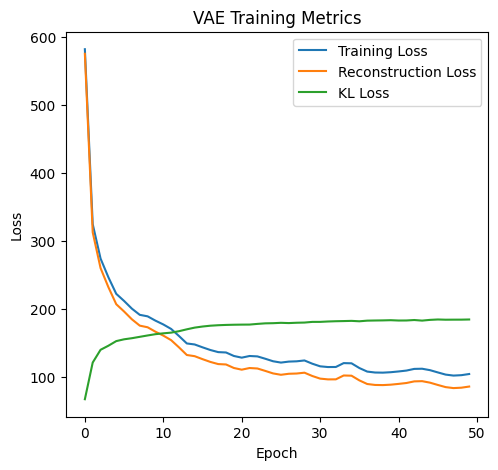

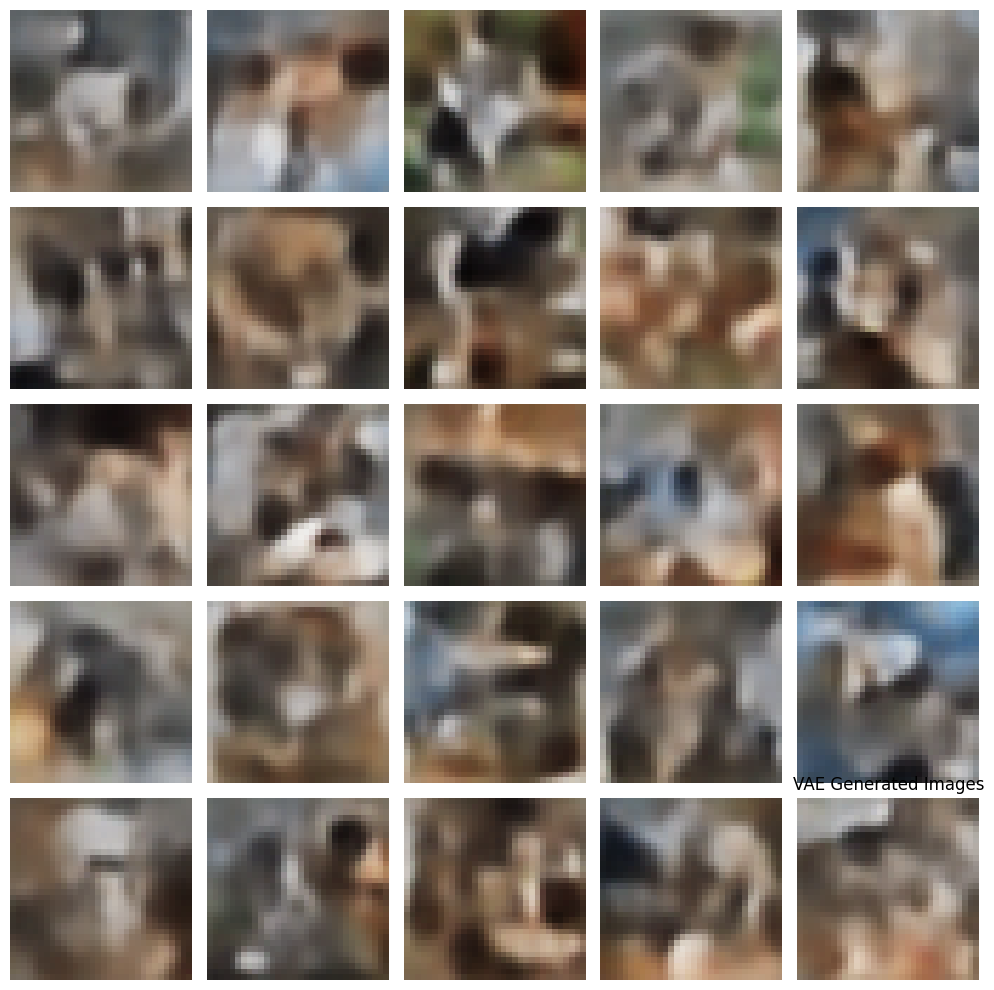


Generating final images from GAN...


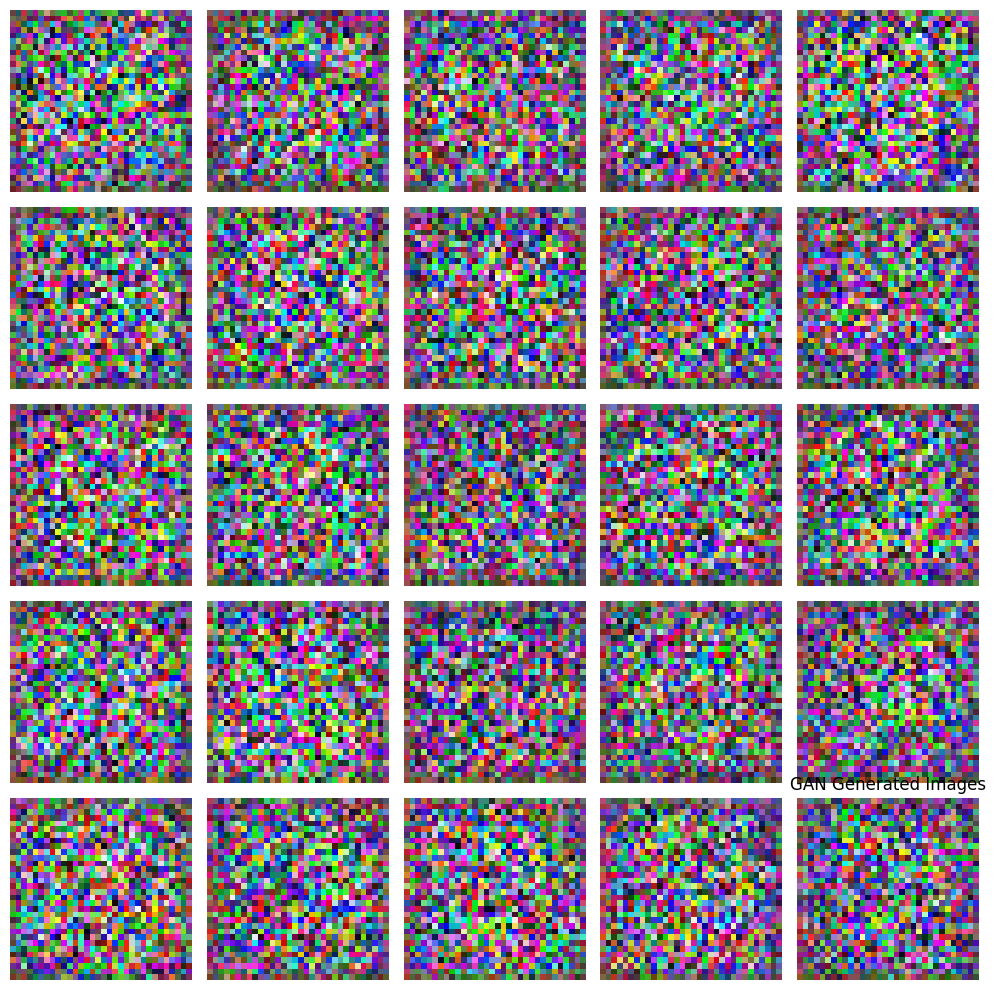

In [33]:

# Plot training history
plt.figure(figsize=(12, 5))

# VAE Loss Plot
plt.subplot(1, 2, 1)
plt.plot(vae_history.history['loss'], label='Training Loss')
plt.plot(vae_history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(vae_history.history['kl_loss'], label='KL Loss')
if 'val_loss' in vae_history.history:
    plt.plot(vae_history.history['val_loss'], label='Validation Loss')
plt.title('VAE Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# # GAN Loss Plot
# plt.subplot(1, 2, 2)
# plt.plot(gan_history.history['d_loss'], label='Discriminator Loss')
# plt.plot(gan_history.history['g_loss'], label='Generator Loss')
# plt.title('GAN Training Metrics')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

# Generate and compare final images
print("\nGenerating final images from VAE...")
vae_images = plot_generated_images(vae, n_rows=5, n_cols=5, is_vae=True)
plt.title("VAE Generated Images")
plt.show()

print("\nGenerating final images from GAN...")
gan_images = plot_generated_images(gan, n_rows=5, n_cols=5)
plt.title("GAN Generated Images")
plt.show()

## Model Evaluation

In [ ]:
# Model Evaluation and Comparison

# Calculate Frechet Inception Distance (simplified version)
def calculate_fid(real_images, generated_images, model=None):
    """Simplified FID calculation using feature vectors"""
    if model is None:
        # Use a pretrained model for feature extraction
        base_model = keras.applications.InceptionV3(include_top=False, pooling='avg')
        model = keras.Model(inputs=base_model.input, outputs=base_model.output)
    
    # Preprocess images for InceptionV3
    real_images_resized = tf.image.resize(real_images, (299, 299))
    real_images_scaled = tf.keras.applications.inception_v3.preprocess_input(
        (real_images_resized * 127.5 + 127.5).numpy()
    )
    
    generated_images_resized = tf.image.resize(generated_images, (299, 299))
    generated_images_scaled = tf.keras.applications.inception_v3.preprocess_input(
        (generated_images_resized * 127.5 + 127.5).numpy()
    )
    
    # Extract features
    real_features = model.predict(real_images_scaled)
    generated_features = model.predict(generated_images_scaled)
    
    # Calculate mean and covariance
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    
    mu_gen = np.mean(generated_features, axis=0)
    sigma_gen = np.cov(generated_features, rowvar=False)
    
    # Calculate FID
    diff = mu_real - mu_gen
    covmean, _ = scipy.linalg.sqrtm(sigma_real.dot(sigma_gen), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

# Calculate structural similarity
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(real_images, generated_images, max_samples=100):
    """Calculate average SSIM between real and generated images"""
    # Take subset of images for calculation
    n_samples = min(len(real_images), len(generated_images), max_samples)
    real_subset = real_images[:n_samples]
    gen_subset = generated_images[:n_samples]
    
    # Convert to 0-1 range for SSIM calculation
    # Check if tensors need conversion to numpy
    if hasattr(real_subset, 'numpy'):
        real_norm = ((real_subset + 1) / 2).numpy()
    else:
        real_norm = ((real_subset + 1) / 2)  # Already numpy array
        
    if hasattr(gen_subset, 'numpy'):
        gen_norm = ((gen_subset + 1) / 2).numpy()
    else:
        gen_norm = ((gen_subset + 1) / 2)  # Already numpy array
    
    # Calculate SSIM for each pair
    ssim_scores = []
    for i in range(n_samples):
        # Use a smaller win_size (must be odd and ≤ smallest image dimension)
        # And explicitly set channel_axis to 2 (for color images with shape HxWxC)
        score = ssim(real_norm[i], gen_norm[i], win_size=3, channel_axis=2, data_range=1.0)
        ssim_scores.append(score)
    
    return np.mean(ssim_scores)

# Generate larger sets of images for evaluation
n_eval = 100
print("Generating images for evaluation...")

# Fix for VAE evaluation
vae_latent = tf.random.normal(shape=(n_eval, 128))  # VAE uses 128-dimensional latent space
vae_eval_images = vae.decoder(vae_latent)

# Fix for GAN evaluation
gan_latent = tf.random.normal(shape=(n_eval, 100))  # GAN uses 100-dimensional latent space  
gan_eval_images = gan.generator(gan_latent)

# Use test images for real comparison
real_eval_images = x_test[:n_eval]

# Calculate metrics
print("\nCalculating evaluation metrics...")
# Note: Import scipy for FID calculation
import scipy

# Calculate FID (might take time)
try:
    vae_fid = calculate_fid(real_eval_images, vae_eval_images)
    gan_fid = calculate_fid(real_eval_images, gan_eval_images)
    print(f"VAE FID Score: {vae_fid:.4f}")
    print(f"GAN FID Score: {gan_fid:.4f}")
except Exception as e:
    print(f"Error calculating FID: {e}")

# Calculate SSIM
vae_ssim = calculate_ssim(real_eval_images, vae_eval_images)
gan_ssim = calculate_ssim(real_eval_images, gan_eval_images)
print(f"VAE SSIM Score: {vae_ssim:.4f}")
print(f"GAN SSIM Score: {gan_ssim:.4f}")

# Visualize VAE reconstructions
n_display = 10
test_indices = np.random.choice(len(x_test), n_display)
test_images = x_test[test_indices]

# Encode and reconstruct with VAE
z_mean, z_log_var, z = vae.encoder(test_images)
reconstructed_images = vae.decoder(z)

# Display original vs reconstructed
plt.figure(figsize=(20, 4))
for i in range(n_display):
    # Original image
    ax = plt.subplot(2, n_display, i + 1)
    # Check if tensor before calling numpy()
    if hasattr(test_images[i], 'numpy'):
        img_display = (test_images[i] * 127.5 + 127.5).numpy().astype(np.uint8)
    else:
        img_display = (test_images[i] * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(img_display)
    plt.title("Original")
    plt.axis("off")
    
    # Reconstructed image
    ax = plt.subplot(2, n_display, i + 1 + n_display)
    if hasattr(reconstructed_images[i], 'numpy'):
        recon_display = (reconstructed_images[i] * 127.5 + 127.5).numpy().astype(np.uint8)
    else:
        recon_display = (reconstructed_images[i] * 127.5 + 127.5).astype(np.uint8)
    plt.imshow(recon_display)
    plt.title("Reconstructed")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

# Compare GAN and VAE generations
plt.figure(figsize=(12, 12))

# Display VAE generated images
for i in range(16):
    plt.subplot(4, 8, i + 1)
    plt.imshow((vae_eval_images[i] * 127.5 + 127.5).numpy().astype(np.uint8))
    plt.title("VAE")
    plt.axis("off")
    
# Display GAN generated images
for i in range(16):
    plt.subplot(4, 8, i + 17)
    plt.imshow((gan_eval_images[i] * 127.5 + 127.5).numpy().astype(np.uint8))
    plt.title("GAN")
    plt.axis("off")
    
plt.tight_layout()
plt.suptitle("Comparison of VAE and GAN Generated Images", y=1.02, fontsize=16)
plt.show()

# Print conclusion
print("\nModel Comparison Summary:")
print("-" * 50)
print("VAE Advantages:")
print("- Smoother training process")
print("- Provides explicit latent space for interpolation")
print("- Can encode existing images")
print("\nGAN Advantages:")
print("- Often produces sharper images")
print("- Better at capturing high-frequency details")
print("- Custom similarity discriminator helps with image quality")
print("\nRecommendation:")
print("Choose VAE for applications requiring both generation and encoding.")
print("Choose GAN for applications prioritizing visual fidelity of generated content.")

ModuleNotFoundError: No module named 'skimage'

## Evaluate Model Performance

Let's evaluate our trained model on the test dataset:

In [ ]:
# Load the best model
best_model = keras.models.load_model(checkpoint_filepath)

# Evaluate on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test_cat, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")

# Make predictions
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(12, 10))
conf_mat = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate class-wise accuracy
class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_accuracy * 100)
plt.title('Class-wise Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
for i, v in enumerate(class_accuracy):
    plt.text(i, v*100 + 1, f"{v*100:.1f}%", ha='center')
plt.tight_layout()
plt.show()

## Make Predictions on New Data

Finally, let's visualize some of our model's predictions on the test data:

In [ ]:
# Select random test examples
num_examples = 25
example_indices = np.random.choice(len(x_test), num_examples, replace=False)
example_images = x_test[example_indices]
example_labels = y_test[example_indices]

# Make predictions
predictions = best_model.predict(example_images)
prediction_classes = np.argmax(predictions, axis=1)

# Display predictions
plt.figure(figsize=(12, 12))
for i in range(num_examples):
    plt.subplot(5, 5, i+1)
    plt.imshow(example_images[i])
    color = 'green' if prediction_classes[i] == example_labels[i] else 'red'
    plt.title(f"True: {class_names[example_labels[i]]}\nPred: {class_names[prediction_classes[i]]}", 
              color=color)
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

# Calculate confidence scores for the examples
plt.figure(figsize=(14, 12))
for i in range(9):  # Show only 9 examples for clarity
    plt.subplot(3, 3, i+1)
    plt.imshow(example_images[i])
    plt.title(f"True: {class_names[example_labels[i]]}")
    plt.axis('off')
    
    # Plot confidence scores
    plt.figtext(0.5, 0.01, f"Example {i+1}", ha="center")
    plt.subplots_adjust(hspace=0.5)
    
    # Create separate subplot for confidence scores
    plt.figure(figsize=(10, 4))
    confidence_scores = predictions[i]
    plt.bar(class_names, confidence_scores)
    plt.title(f"Prediction Confidence for Example {i+1}")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    for j, score in enumerate(confidence_scores):
        plt.text(j, score + 0.05, f"{score:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:
# Save the complete model
model.save('cifar10_cnn_model.h5')
print("Model saved successfully!")

# Summarize what we've learned
print("\nModel Performance Summary:")
print(f"Final accuracy on the test set: {test_acc:.4f}")
print(f"Top-3 best performing classes: {np.argsort(class_accuracy)[-3:][::-1]}")
print(f"Bottom-3 worst performing classes: {np.argsort(class_accuracy)[:3]}")

# Suggestions for improvement
print("\nPotential improvements:")
print("1. Train for more epochs or use a larger model")
print("2. Try more aggressive data augmentation")
print("3. Implement transfer learning with a pre-trained model")
print("4. Use learning rate scheduling")
print("5. Try different optimizers or regularization techniques")